# Mercari Price Prediction Project 
##  - Part 2 Feature Engineering and Text Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")

/Users/inaba3910/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# load dataset
train = pd.read_csv('eda_train.csv')
test = pd.read_csv('.//data/test.tsv', sep='\t')

In [4]:
# size of training and testing datasets
print(train.shape)
print(test.shape)

(1482535, 12)
(693359, 7)


## Basic Text Preprocessing, Feature Engineering, and Continued EDA

### Item Description
#### Feature Engineering - 1st feature description length
<br> Based on my intuition and research on existing approaches, I came up with the following features that I thought would be useful in determining the price of an item. There is no standard rule for using these features, these are purely intuition-based ideas which may vary from problem to problem.
<br>
<br> Also, as the length of the item description or the item name decreases, the cost of the product seems to increase. Since I observe a fair amount of correlation between the price and length of the item desription/name, I consider item description length and name length as additional features in the dataset.

In [5]:
# calculate raw description and name length
def length(description):
    count = 0
    for i in description.split():
        count+=1
    return count


lol = []
lol2 = []
for i in train['item_description']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    lol.append(temp)

for i in train['name']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    lol2.append(temp)
print(lol[0])
print(len(lol))

['No description yet', 3]
1482535


In [6]:
# check
mydf1 = pd.DataFrame(lol,columns=['desc','desc_length'])
print(mydf1.head(2))

                                                desc  desc_length
0                                 No description yet            3
1  This keyboard is in great condition and works ...           36


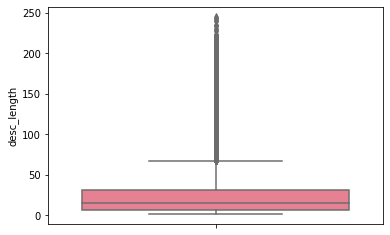

In [7]:
# box-plot of description length
sns.set_palette("husl")
sns.boxplot(x=mydf1.desc_length,orient='v')

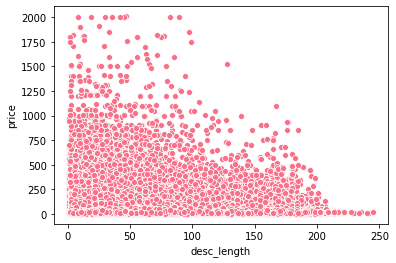

In [8]:
# scatter-plot of description length with price
sns.scatterplot(x=mydf1.desc_length,y=train.price)

We can see from above that most of the descriptions are short and less than 50 characters. It also seems that the longer the description, the lower the price.

#### Feature Engineering - 2nd feature name length

In [9]:
# check
mydf2 = pd.DataFrame(lol2,columns=['name','name_length'])
print(mydf2.head(2))

                                  name  name_length
0  MLB Cincinnati Reds T Shirt Size XL            7
1     Razer BlackWidow Chroma Keyboard            4


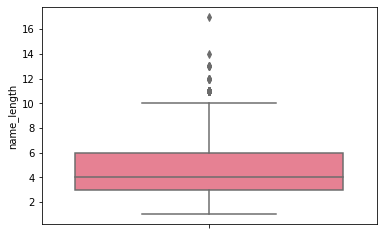

In [10]:
# box-plot of name length
sns.boxplot(x=mydf2.name_length,orient='v')

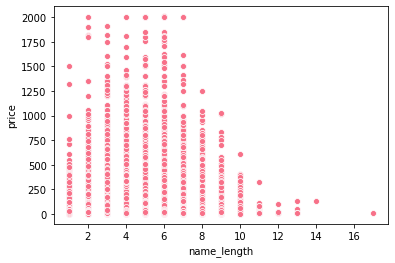

In [11]:
# scatter-plot of name length with price
sns.scatterplot(x=mydf2.name_length,y=train.price)

Here, the name length has the same pattern as the description length that most of the names are very short, and the longer the name length, the cheaper the price.

In [12]:
train['name_len'] = mydf2['name_length']
train['desc_len'] = mydf1['desc_length']
train.head(3)

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts    Unknown   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   

   shipping                                   item_description  log_price  \
0         1                                 No description yet   2.397895   
1         0  This keyboard is in great condition and works ...   3.970292   
2         1  Adorable top with a hint of lace and a key hol...   2.397895   

      main_cat              subcat1             subcat2  name_len  desc_len  
0          Men                 Tops            T-shirts         7         3  
1  Electronics  Computers & Tablets  Components & Parts         4        36  
2        Women       Tops & Blouses              Blouse         2        29

In [13]:
# we can observe the tendency of cheaper price with description length increase with its mean value
df = train.groupby('desc_len')['price'].mean().reset_index()

trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Price by Description Length',
              yaxis = dict(title='Average Price'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
iplot(fig)

#### Basic Text Preprocessing and WordCloud on Item Description

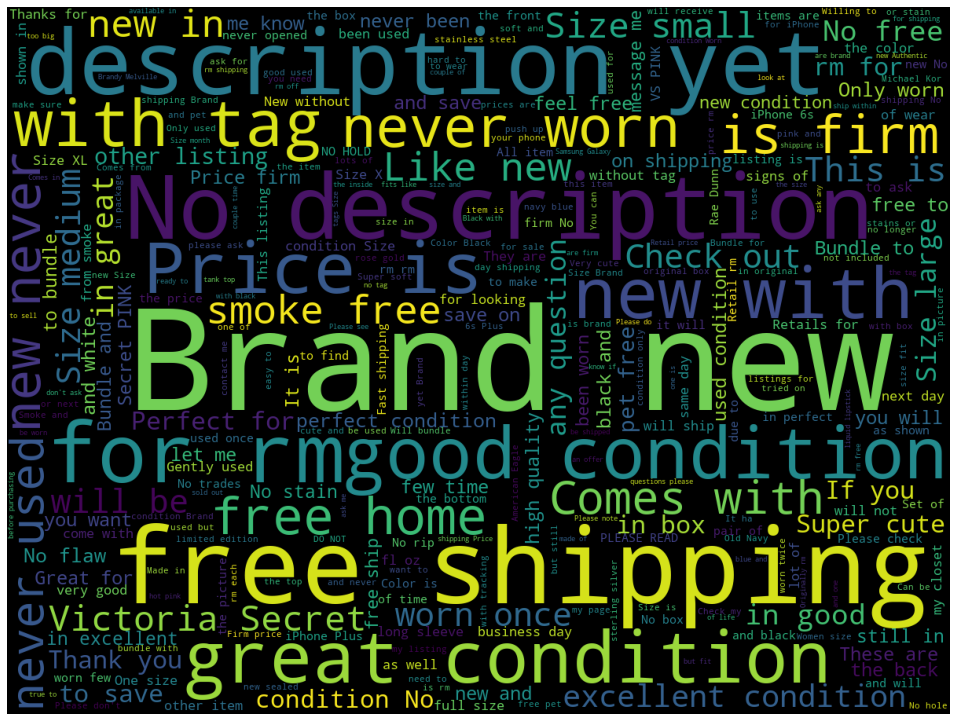

In [13]:
from wordcloud import WordCloud
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train.item_description.astype(str)))
plt.figure(figsize = (18, 13))
plt.imshow(wc)
plt.axis("off")
plt.show()

Based on the WordCloud above, except for the imputed text for significant missingness, in item description most mentioned are item conditions (new, with tag, excellent condition, etc.), brand, sizing, and shipping. These were mentioned the most might because of the fact that most items fall into women apparel or beauty categories.

In [14]:
# text preprocessing 
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
# preprocessing 'item_description' for train set
preprocessed_desc_train = []
for sentance in train['item_description'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_desc_train.append(sent.lower().strip())

# after preprocesing
preprocessed_desc_train[0]

# preprocessing 'item_description' for test set
preprocessed_desc_test = []
for sentance in test['item_description'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_desc_test.append(sent.lower().strip())

# after preprocesing
preprocessed_desc_test[0]

'size 7'

#### Feature Engineering - 3rd feature sentiment polarity scores
<br> The hypotheses here was that the better sentiment an item is conveyed with in item description, the higher the buyers are willing to pay for the item. I expected a positive co-relation between sentiment scores of item description and price.

In [16]:
# calculating polarity scores in negative, neutral, positive, and compounding
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

train_sentiment = []; 
for sentence in preprocessed_desc_train:
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    train_sentiment.append(ss)
    
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in train_sentiment:   
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)
            


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/inaba3910/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
train['negative']=negative
train['neutral']=neutral
train['positive']=positive
train['compound']=compounding

In [18]:
# get all preprocessed data into a new df
train_preprocessed= train[['train_id','name','item_condition_id','log_price','brand_name','shipping', \
                           'item_description','name_len','desc_len','main_cat','subcat1','subcat2', \
                          'negative','neutral','positive','compound']]


## Correlation between Features

In [19]:
train_numeric= train[['log_price','shipping','name_len','desc_len','negative','neutral','positive','compound']]

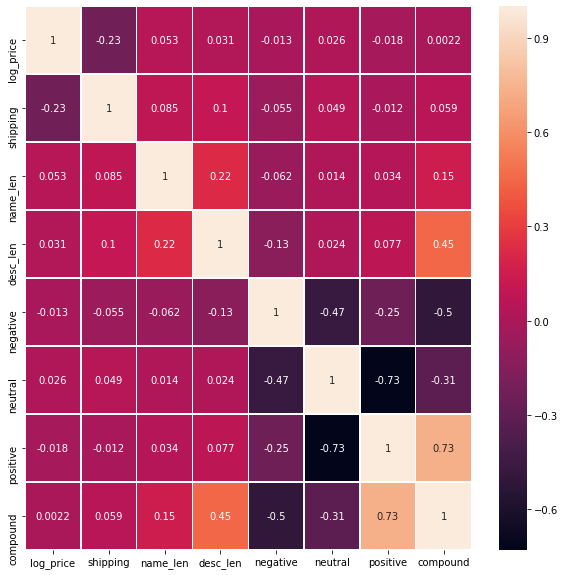

In [20]:
# heatmap
plt.figure(figsize = (10, 10))
sns.heatmap(train_numeric.corr(), annot = True, linewidth = 0.5)
plt.show()

It looks like the log_price is highly correlated with shipping, and the polarity scores are highly correlated with each other.

## Basic Preprocessing Procedures on Test Data and Save Train and Test Files

In [22]:
# fill missing values with strings indicating 'not specified'
def fill_miss(data):
    data.category_name.fillna(value = "Other/Other/Other", inplace = True)
    data.brand_name.fillna(value = "Unknown", inplace = True)
    data.item_description.fillna(value = "No description", inplace = True)
    return data

train = fill_miss(train)

In [23]:
# fill missing values
test = fill_miss(test)
print(test.isnull().any())
# split category names
test["main_cat"] = test.category_name.str.extract("([^/]+)/[^/]+/[^/]+")
test["subcat1"] = test.category_name.str.extract("[^/]+/([^/]+)/[^/]+")
test["subcat2"] = test.category_name.str.extract("[^/]+/[^/]+/([^/]+)")
# calculate item_description length
lol = []
lol2 = []
for i in test['item_description']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    lol.append(temp)
# calculate name length
for i in test['name']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    lol2.append(temp)
# append new features to test dataset    
mydf1 = pd.DataFrame(lol,columns=['desc','desc_length'])
test['desc_len'] = mydf1['desc_length']
mydf2 = pd.DataFrame(lol2,columns=['name','name_length'])
test['name_len'] = mydf2['name_length']

test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
dtype: bool


In [26]:
# calculate polarity scores
test_sentiment = []; 
for sentence in preprocessed_desc_test:
    for_sentiment = sentence
    ss = sid.polarity_scores(for_sentiment)
    test_sentiment.append(ss)
    
negative=[]
neutral=[]
positive=[]
compounding=[]
for i in test_sentiment:   
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative.append(score)
        if(polarity=='neu'):
            neutral.append(score)
        if(polarity=='pos'):
            positive.append(score)
        if(polarity=='compound'):
            compounding.append(score)
# append new columns to test dataset            
test['negative']=negative
test['neutral']=neutral
test['positive']=positive
test['compound']=compounding

In [27]:
# get all preprocessed data into a new df
test_preprocessed= test[['test_id','name','item_condition_id','brand_name','shipping', \
                           'item_description','name_len','desc_len','main_cat','subcat1','subcat2', \
                          'negative','neutral','positive','compound']]

In [28]:
# save two dataset to csv files for modeling use
train_preprocessed.to_csv('df_train.csv', index = False)
test_preprocessed.to_csv('df_test.csv', index = False)